In [52]:
import json
import os
import sys
import importlib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="ticks", color_codes=True)

import tensorflow as tf
print('Python version:', sys.version)
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Python version: 3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


## Preprocess varying-length synthesized-data

In [2]:
import pickle

data_path_prefix = '/Users/lun/Documents/share/project-basileus/time-lstm/data/varying_length'
valid_seqs_filename = 'valid_sequences.pickle'
invalid_seqs_filename = 'invalid_sequences.pickle'

with open(os.path.join(data_path_prefix, valid_seqs_filename), 'rb') as f:
    valid_seqs = pickle.load(f)
    
with open(os.path.join(data_path_prefix, invalid_seqs_filename), 'rb') as f:
    invalid_seqs = pickle.load(f)

In [3]:
event_type_seqs = []
delta_time_seqs = []

for seq in valid_seqs + invalid_seqs:
    _ets, _dts = [], []
    ts_prev = 0
    for et, ts in seq:
        _ets.append(et + 1) # 0 is for padding, standing for 'N/A' 
        _dts.append(ts-ts_prev)
        ts_prev = ts
    event_type_seqs.append(_ets)
    delta_time_seqs.append(_dts)
        
label_list = [0] * len(valid_seqs) + [1] * len(invalid_seqs)

## Pad and create dataset

In [21]:
padding_len = 20
N = len(label_list)
padding_type = 'post'
truncating_type = 'pre'

# padding event types
padded_et = tf.keras.preprocessing.sequence.pad_sequences(
    event_type_seqs, 
    padding=padding_type, 
    truncating = truncating_type,
    maxlen=padding_len,
    value=0,
    dtype=int,
)

#padding time stamps
padded_ts = tf.keras.preprocessing.sequence.pad_sequences(
    delta_time_seqs, 
    padding=padding_type, 
    truncating = truncating_type,
    maxlen=padding_len,
    value=0,
    dtype=float,
)

padded_et = padded_et.reshape((N, padding_len,1))
padded_ts = padded_ts.reshape((N, padding_len,1))
labels = np.array(label_list).reshape((N,1))

features = (padded_et, padded_ts)

def create_dataset(batch_size=2, epochs=10, buffer_size=1000):
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

## Build model for simple discriminator D to detemine valid/invalid
### also test if Gaussian mixture model can model the time delta distribution

In [22]:
from tensorflow.keras.models import Model
tf.keras.backend.set_floatx('float64')

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
import tensorflow_probability as tfp
tfd = tfp.distributions

module_path = '/Users/lun/Documents/share/project-basileus/time-lstm/time_lstm_modules'
if module_path not in sys.path:
    sys.path.append(module_path)

if 'TimeLSTM' in sys.modules:
    importlib.reload(sys.modules['TimeLSTM'])
    
from TimeLSTM import TimeLSTM1

In [37]:
T = 20
batch_size = 3
emb_dim = 2
vocab = ['na', 'start', 'view', 'click', 'install']

# Time-LSTM:
i_et = Input(shape=(T,1), name='event_type')  # input of discrete feature event type
i_ts = Input(shape=(T,1), name='time_delta')  # input of continuous feature timestamp
mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(20, 1))
masked_ts = mask_layer(i_ts)

embed0 = Embedding(input_dim=len(vocab), output_dim=emb_dim, input_length=20, mask_zero=True,
                   batch_input_shape=[batch_size, None])(i_et) 
embed0 = Reshape((T, emb_dim))(embed0) # shape=[Batch_size, 20, 16]
merged0 = tf.keras.layers.concatenate([embed0, masked_ts], axis=2) # # shape=[Batch_size, 20, 17]
 
hm, tm = TimeLSTM1(100, activation='selu', name='time_lstm', return_sequences=False)(merged0)

# tfp.layers.MixtureNormal(num_components, event_shape)

# gaussian mixture for time delta
k_mixt = 4
alpha = Dense(k_mixt, activation=tf.nn.softmax, name='dense_alpha')(tm)
mu = Dense(k_mixt, activation=None, name='dense_mu')(tm)
sigma = Dense(k_mixt, activation=tf.nn.softplus,name='dense_sigma')(tm)

gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(
        probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu, 
            scale=sigma))

gaussian_log = gm.log_prob(masked_ts)# apply gaussian mixture to time stamp input


# mask out zeros in time stamps
mask = tf.not_equal(i_ts, 0)
# gaussian_log = tf.boolean_mask(gaussian_log, mask)
# time_delta = tf.boolean_mask(i_ts, mask)

# predicted fraud prob
fraud_prob = Dense(1, activation='sigmoid',name='fraud_prob')(hm)

model_a = Model(
    inputs=[i_et, i_ts], 
    outputs=[fraud_prob, gaussian_log, mask])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4


## Time-LSTM, Gaussian Mixture Model Training

In [54]:
optimizer = Adam(lr=0.001)
# optimizer = SGD(learning_rate=1e-4)

DATA_SIZE = N
EPOCHS = 3
BATCH_SIZE = 64


dataset = create_dataset(batch_size=BATCH_SIZE, epochs=EPOCHS, buffer_size=DATA_SIZE)
step = 0
loss_history = [[],[]]
total_steps = EPOCHS * DATA_SIZE // BATCH_SIZE

def harmonic_mean(a, b):
    return 2 / (1/a + 1/b)

In [39]:
for features_batch, labels_batch in dataset.take(total_steps):
    step += 1
    with tf.GradientTape() as tape:
        fraud, gaussian_log, mask = model_a(features_batch)

#         print(features[1])
#         print('tm:{}'.format(tm))
#         tk = [weight for weight in model_a.weights if 'time_kernel' in weight.name or 'kernel' in weight.name]
#         print(tk)

        # calculate masked neg-likelihood of gaussian mixture
        gaussian_log = gaussian_log[:, :, 0:1]
        gaussian_log = tf.boolean_mask(gaussian_log, mask)
        gaussian_loss = -tf.reduce_mean(gaussian_log)
        
#         if step % 20 == 0:
        print('gaussian loss:{}'.format(gaussian_loss))

        # cross-entropy loss
        ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(labels_batch, fraud, from_logits=False))
        print('ce loss:{}'.format(ce_loss))
        total_loss = gaussian_loss + ce_loss

    loss_history[0].append(gaussian_loss.numpy())
    loss_history[1].append(ce_loss.numpy())
    
#     print('loss:{}'.format(loss.numpy()))
    grads = tape.gradient(total_loss, model_a.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_a.trainable_variables))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

gaussian loss:880.3551639666274
ce loss:0.6894540104774358
gaussian loss:955.1386354585454
ce loss:0.6823139526830377
gaussian loss:229.426799445855
ce loss:0.6815812939261074
gaussian loss:804.4051785499945
ce loss:0.6716838060328019
gaussian loss:416.77754200932
ce loss:0.6653955987033943
gaussian loss:509.6219576151881
ce loss:0.6572577815793377
gaussian loss:302.74644944311586
ce loss:0.6472015442069032
gaussian loss:555.6643749800114
ce loss:0.6339812848000965
gaussian loss:170.37837237620596
ce loss:0.6260773484725667
gaussian loss:214.1821040884806
ce loss:0.6028043183292937
gaussian loss:149.86280345057176
ce loss:0.5662062143463436
gaussian loss:288.4964796181544
ce loss:0.5228193616145521
gaussian loss:274.41390856349744
ce loss:0.5469972691813869
gaussian loss:146.0972592767497
ce loss:0.45354913626421567
gaussian loss:656.2240171288664
ce loss:0.4676708586307728
gaussian loss:291.60653278633674
ce loss:0.48051542997899
gaussian loss:300.51699445345844
ce loss:0.502546068633

gaussian loss:28.709767612101853
ce loss:0.2742219690970842
gaussian loss:17.411765780868127
ce loss:0.44461680131076997
gaussian loss:32.66869413362254
ce loss:0.37654972237684836
gaussian loss:24.963939379965716
ce loss:0.4022000513589523
gaussian loss:53.77526142115834
ce loss:0.26419383912619565
gaussian loss:35.38275593767425
ce loss:0.2860823015264423
gaussian loss:34.25957524821482
ce loss:0.3883702054303367
gaussian loss:34.01938938798431
ce loss:0.27048179368426317
gaussian loss:27.495267401287297
ce loss:0.32509932467905006
gaussian loss:27.35706023500362
ce loss:0.30889702018823695
gaussian loss:23.906851991114515
ce loss:0.39188043392398586
gaussian loss:32.10817845193036
ce loss:0.2849696754166114
gaussian loss:28.235334720407877
ce loss:0.36849225075987196
gaussian loss:8.132925528260195
ce loss:0.37135769147694087
gaussian loss:22.57463818728892
ce loss:0.3015187464143675
gaussian loss:24.416735785088456
ce loss:0.34793864832664106
gaussian loss:26.209797506255914
ce los

gaussian loss:10.913154447656893
ce loss:0.18905217244833605
gaussian loss:13.130339757763956
ce loss:0.18472940920415323
gaussian loss:11.970042842729656
ce loss:0.15642827733448936
gaussian loss:12.909833586546773
ce loss:0.0840146622386683
gaussian loss:26.17405118777939
ce loss:0.18540977373651393
gaussian loss:12.586138689518927
ce loss:0.2373081717766762
gaussian loss:14.87861743065726
ce loss:0.16941645270708597
gaussian loss:8.821097742441678
ce loss:0.21502994095338854
gaussian loss:13.14842913761379
ce loss:0.26416561331213306
gaussian loss:19.37795560405593
ce loss:0.23439772006025963
gaussian loss:24.601678553165282
ce loss:0.2022202470624705
gaussian loss:8.443593563748268
ce loss:0.19297526731042805
gaussian loss:20.326633859026966
ce loss:0.22874567770356052
gaussian loss:14.54660703977917
ce loss:0.11683268682401786
gaussian loss:22.33745357210844
ce loss:0.1907908058067081
gaussian loss:17.02995250191009
ce loss:0.17016276317814563
gaussian loss:26.08603584474726
ce lo

In [41]:
gaussian_loss_history, ce_loss_history = loss_history

## Plot the loss history

<IPython.core.display.Javascript object>


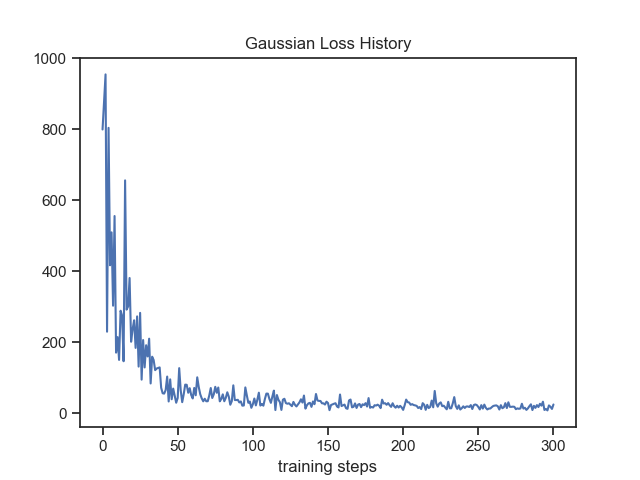

Text(0.5, 0, 'training steps')

In [53]:
x = range(len(gaussian_loss_history))
plt.figure(dpi=100)
plt.plot(x, gaussian_loss_history)
plt.title('Gaussian Loss History')
plt.xlabel('training steps')

<IPython.core.display.Javascript object>


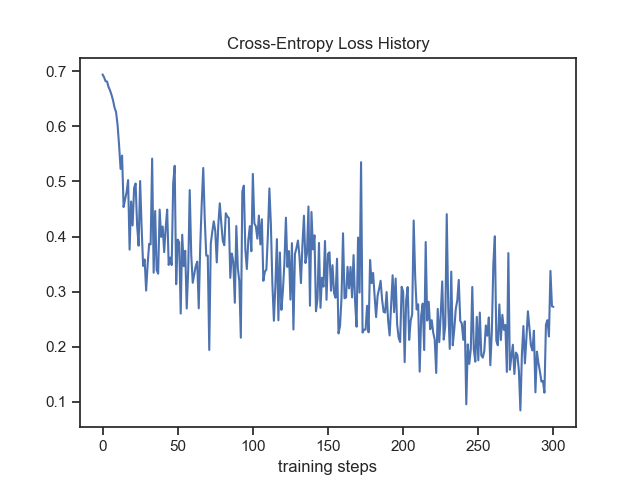

Text(0.5, 0, 'training steps')

In [51]:
x = range(len(ce_loss_history))
plt.figure(dpi=100)
plt.plot(x, ce_loss_history)
plt.title('Cross-Entropy Loss History')
plt.xlabel('training steps')